# Training the model
Here, we will explore several things:
1. Establishing the baseline performance using RandomForest
2. Trying out different tree-based models to outperform RandomForest
3. Adjusting the cutoff threshold for prediction probabilities, for our specific use case

In [1]:
import os

os.chdir("../")

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

from src.model import BinaryClassifierModel
from src.preprocess import Preprocessor

In [3]:
DATA_PATH = os.path.join(os.getcwd(), "data", "heart.csv")

In [4]:
TARGET_COL = "HeartDisease"

In [5]:
df = pd.read_csv(DATA_PATH)

In [6]:
df = df.reset_index(drop=True)

In [7]:
X_raw = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]

<AxesSubplot: xlabel='HeartDisease', ylabel='count'>

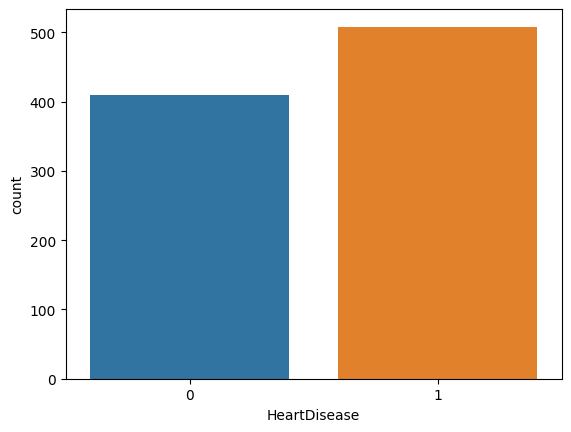

In [8]:
sns.countplot(data=df, x=TARGET_COL)

We are dealing with quite well-balanced dataset

In [9]:
model = BinaryClassifierModel(
    model=RandomForestClassifier(random_state=42), preprocessor=Preprocessor()
)

In [10]:
param_grid = {
    "n_estimators": [1000],
    "random_state": [42],
    "max_features": [0.8],  # 0.3, 0.5, 
}

# Use no encoded categorical features

In [11]:
X_numeric_only = X_raw.select_dtypes(["number"])  # Drop all non-numerical columns

In [12]:
model.fit(
    X_numeric_only, y, param_grid=param_grid, metrics=["f1", "accuracy", "precision", "recall"]
)

f1: 0.757, precision: 0.773, recall: 0.742


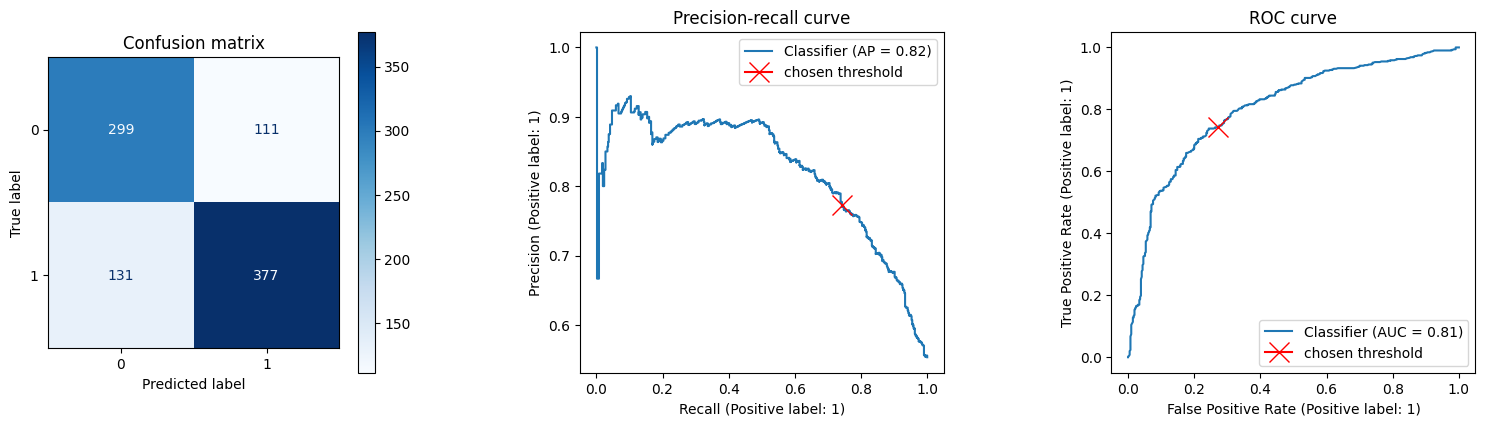

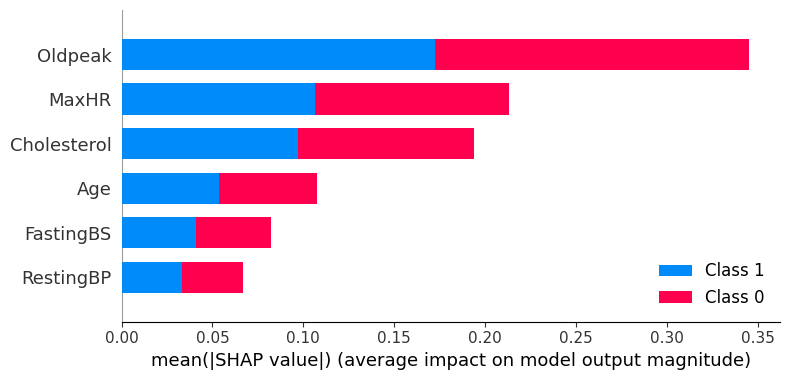

In [13]:
model.evaluate(X_numeric_only, y)

# Use the encoded categorical features

In [14]:
X_with_cat_feats = model.preprocess(X_raw)

In [15]:
model.fit(
    X_with_cat_feats, y, param_grid=param_grid, metrics=["f1", "accuracy", "precision", "recall"]
)

f1: 0.857, precision: 0.852, recall: 0.862


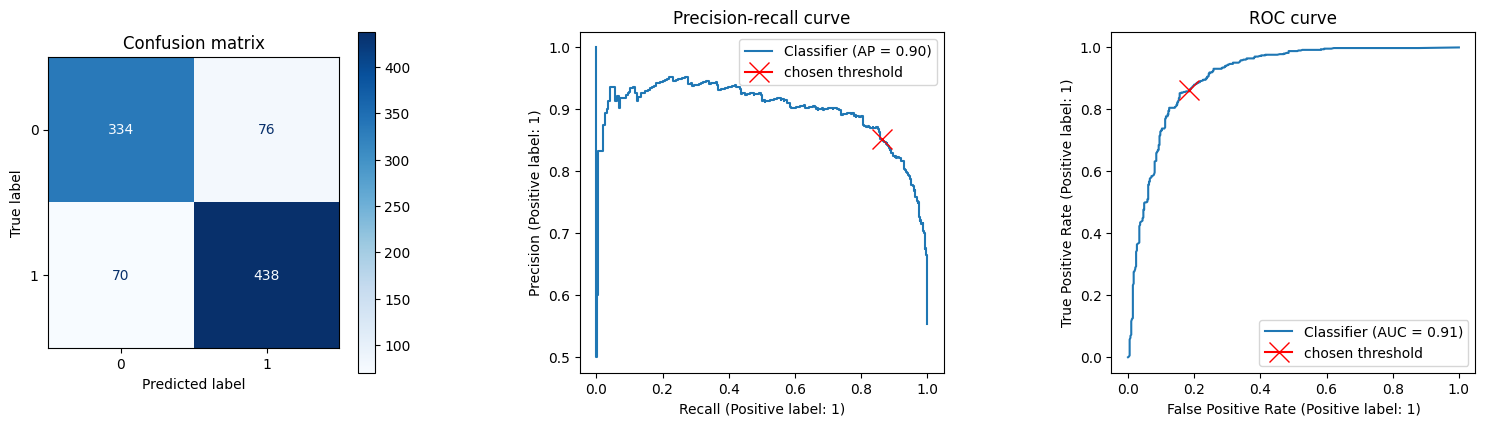

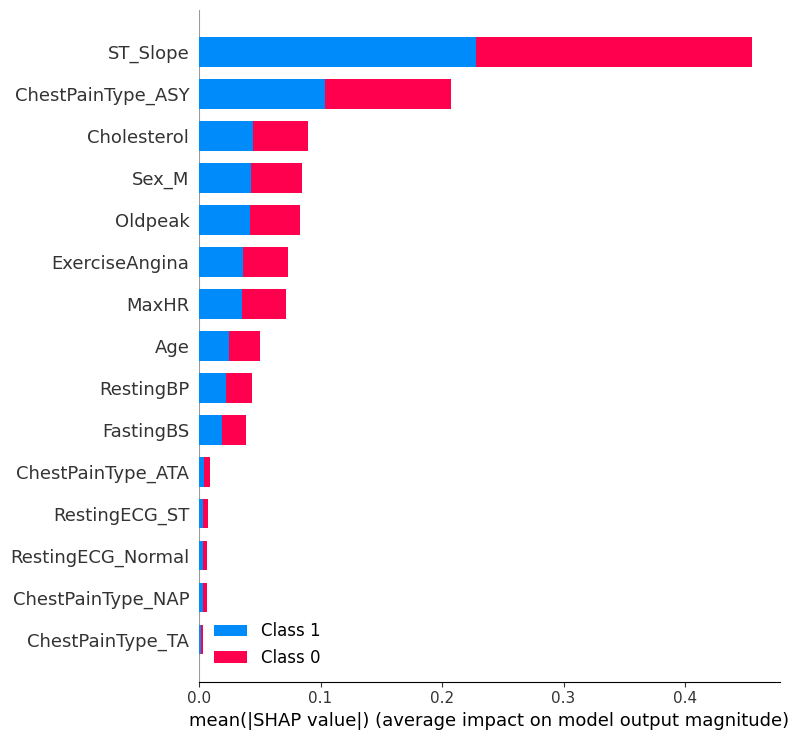

In [17]:
model.evaluate(X_with_cat_feats, y)

---

### Adjust cutoff point for prediction selection
`Precision = When the prediction is positive, how often is it correct?`

`Recall = How many of the true positive cases are we catching?`

In this particular use case, we might favor `Recall` over `Precision` because we want to uncover as many potential heart failures as possible. Then, the patients with positive prediction might be sent for further, more detailed investigation.

Let's adjust the cutoff threshold for predictions at a level that would ensure some decent level of `Recall` at the expense of `Precision`.

In [18]:
model.select_threshold_based_on_recall(X_with_cat_feats, y, min_recall=0.95)

f1: 0.862, precision: 0.788, recall: 0.951


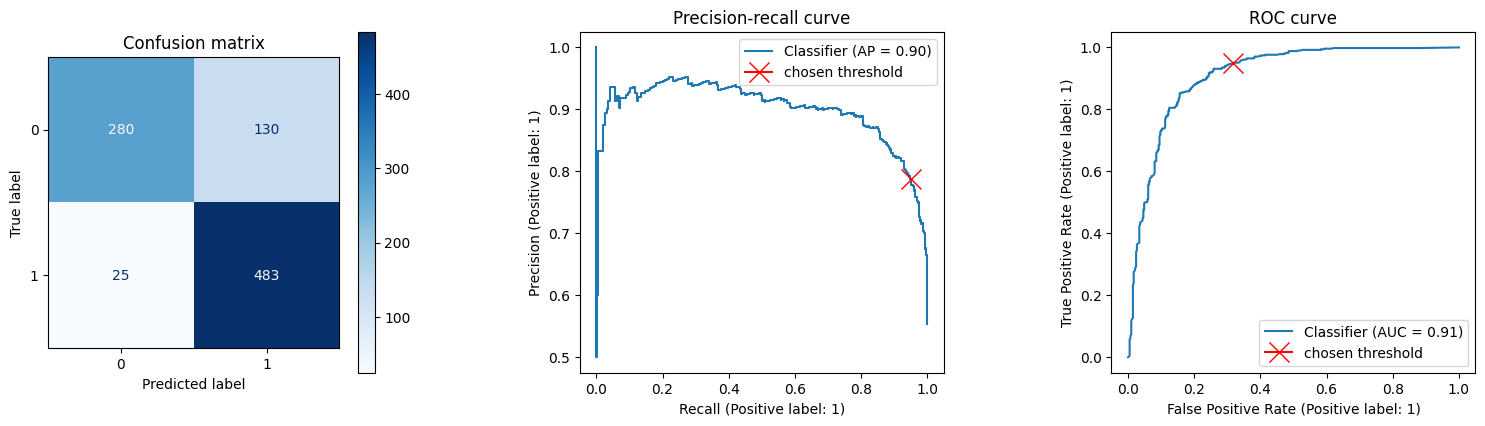

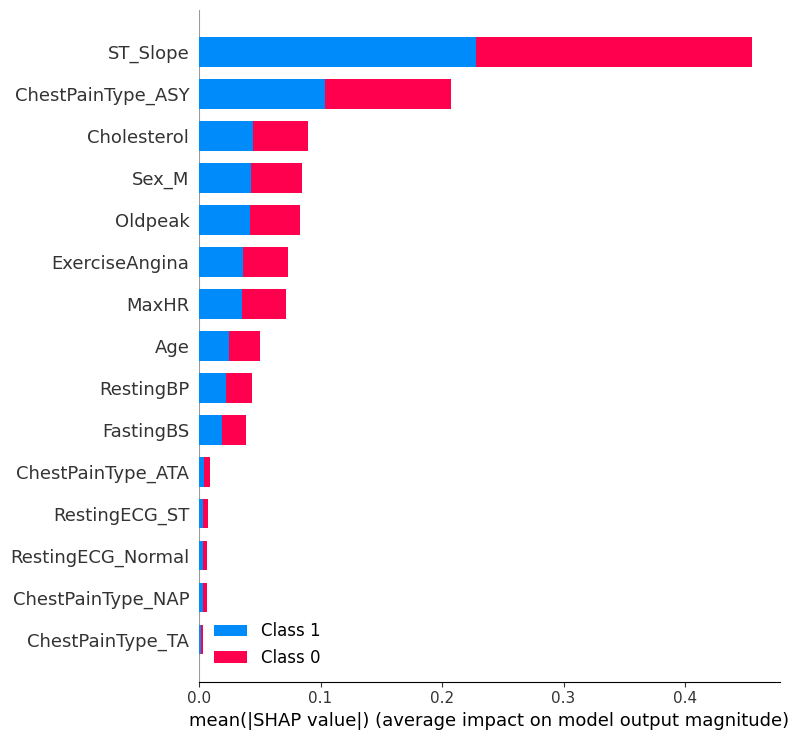

In [19]:
model.evaluate(X_with_cat_feats, y)

---

### LightGBM

In [20]:
import lightgbm as lgb

In [21]:
lgb_model = BinaryClassifierModel(
    model=lgb.LGBMClassifier(random_state=42), 
    preprocessor=Preprocessor(),
)

In [23]:
param_grid = {
    "max_depth" : [-1, 4, 8],  # How deep a tree can go. More -> More complexity
    "num_leaves" : [2, 8, 31],  # Each new tree will have max this amount of leaf nodes. More -> More complexity
    "feature_fraction": [0.5, 0.8],  # Subset of features to select on each new iteration
    "reg_alpha": [0, 0.3, 0.7],
    "reg_lambda": [0, 0.3, 0.7],
    "learning_rate": [0.03, 0.1, 0.9],
    "verbose": [-1],
}

In [24]:
%%capture
lgb_model.fit(
    X_with_cat_feats, y, param_grid=param_grid, metrics=["f1", "accuracy", "precision", "recall"]
)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGB

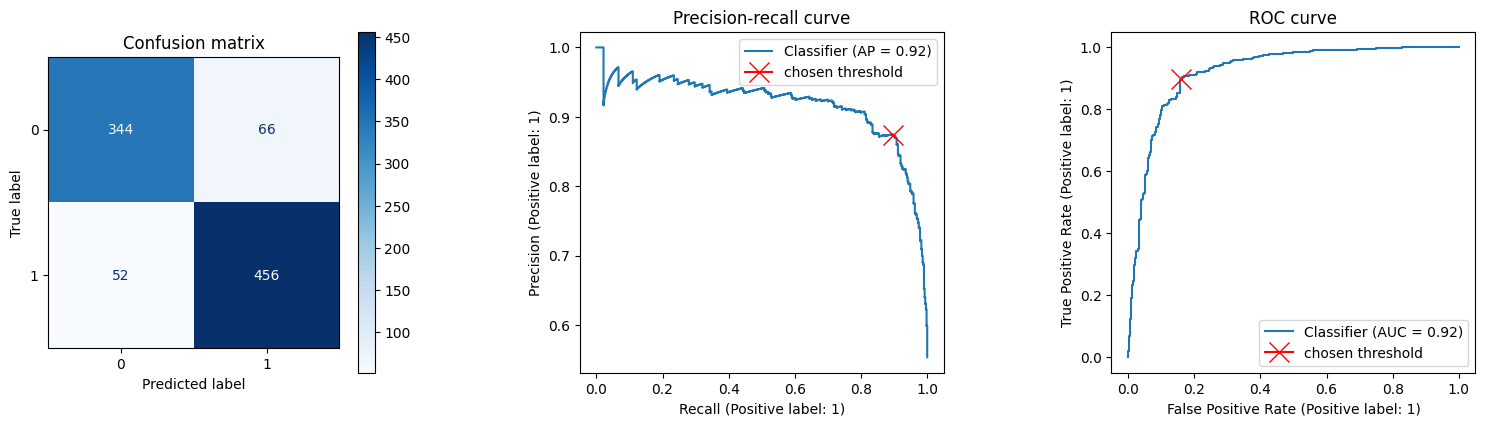

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


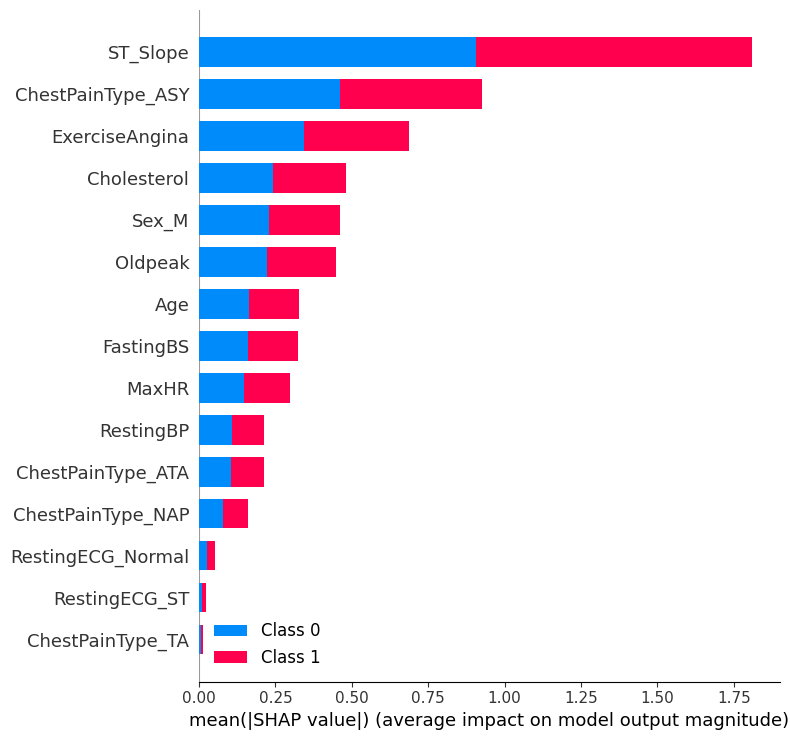

In [25]:
lgb_model.evaluate(X_with_cat_feats, y)

# XGBoost

In [26]:
from xgboost import XGBClassifier

In [27]:
xgb_model = BinaryClassifierModel(
    model=XGBClassifier(random_state=42),
    preprocessor=Preprocessor(),
)

In [28]:
param_grid = {
    "max_depth" : [3, 6, 10],  # How deep a tree can go. More -> More complexity
    "subsample" : [0.3, 0.5, 0.8],  # fraction of observations to be randomly sampled for each tree
    "colsample_bytree": [0.5, 0.8],  # Similar to max_features in GBM
    "alpha": [0, 0.3, 0.7],  # analogous to Lasso regression
    "lambda": [0, 0.3, 0.7],  # analogous to Ridge regression
    "learning_rate": [0.03, 0.1, 0.9],
    "verbose": [-1],
}

In [29]:
%%capture
xgb_model.fit(
    X_with_cat_feats, y, param_grid=param_grid, metrics=["f1", "accuracy", "precision", "recall"]
)

[20:13:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:13:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:13:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9

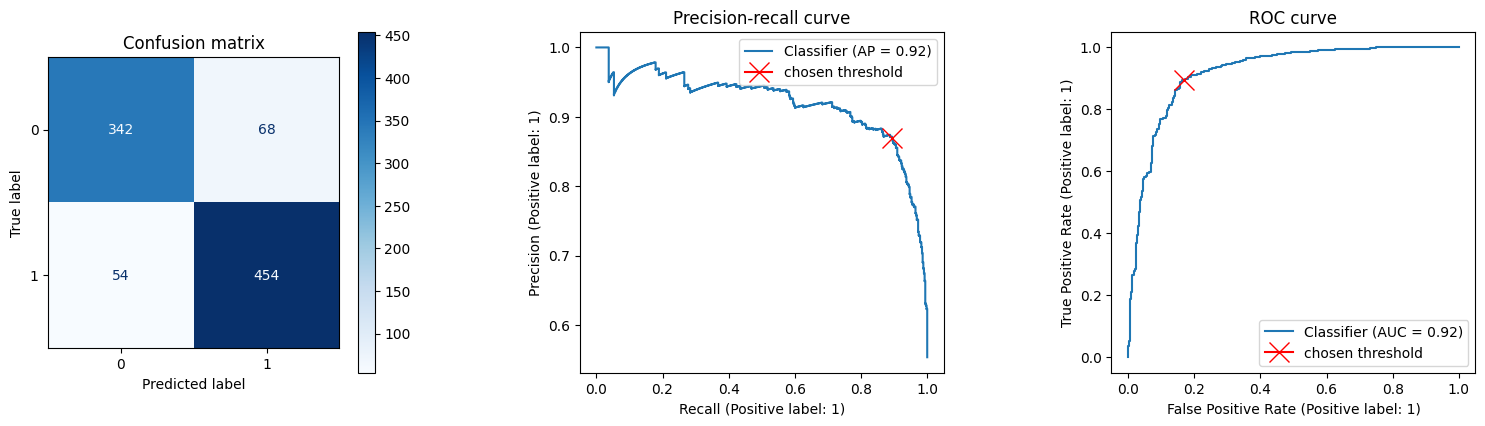

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


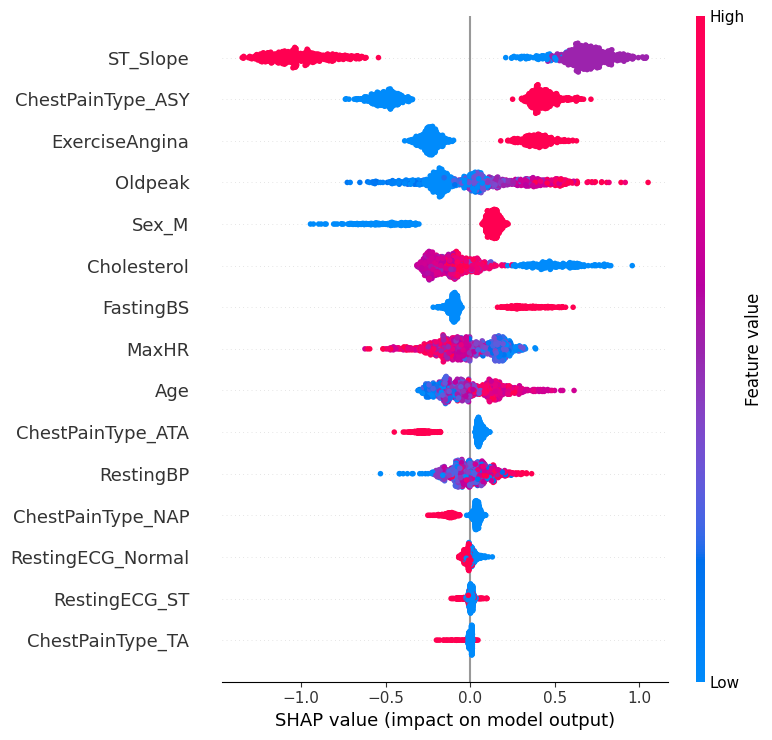

In [30]:
xgb_model.evaluate(X_with_cat_feats, y)

---

# Conclusion
All models have similar performance, LightGBM outperforms slightly. Most impact on performance comes from data preprocessing.

---